To add:
- locally weighted
- L1/L2 Regularization
- ADAM/lbfgs...
- gradient clippings

Learned:
- Gradient explosion, if learning rate too high, updates begin to spiral as each sequential update over corrects
- Add the intercept term to dataset as extra col before doing any modeling
- Data scaling, can mess up model as certain features become much more impactful on linear combination
- OOP is necessary, super convenient way to store/access data, much cleaner, barely any info passed as args, 
but there is a balance, easy to lose track of what objects are being handeled
- Convert pd to np, faster and np very contained
- Lot of convenient interactions with pd: use documentation/chat, if you think it exists, probably does
- Experiment with epochs, learning rates, and grad types, just gotta tune it slightly and monitor costs/grads
- Shuffle data in mini-batches: less noise

In [33]:
#import libraries and dataset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

boston_df = pd.read_csv('boston.csv')

inverse link and cost functions

In [34]:
def linear_identity(theta, input):
    return input @ theta

def linear_MSE(theta,X,Y):
    return np.mean((((X @ theta)  - Y) ** 2)/2)

def logit_sigmoid(theta, input):
    return 1 / (1 + np.exp(-(input @ theta)))

def logit_loss(theta,X,Y,epsilon=1e-15):
    sigmoid = logit_sigmoid(theta, X)
    sigmoid = np.clip(sigmoid, epsilon, 1 - epsilon)
    return np.mean(-(Y*np.log(sigmoid) + (1-Y)*(np.log(1-(sigmoid)))))

GLM class

In [35]:
class GLM:
    #allows user to pick own learning_rate, max_epochs, convergence_level, and threshold values
    def __init__(self, GLM_type, learning_rate = 0.001, max_epochs = 1000,
                 convergence_level = .00001):
        #assigning attributes
        self.convergence_level = convergence_level
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.cost_storage = None
        self.theta = None
        self.batch_size = None
        self.threshold = None

        if GLM_type == "linear":
            self.inverse_link = linear_identity
            self.cost = linear_MSE
        elif GLM_type == "logit":
            self.inverse_link = logit_sigmoid
            self.cost = logit_loss
        
        self.GLM_type = GLM_type
        
    #fit method which does the hardwork
    #choose dataset, features, response, gradient descent type,
    #batch size if mini-batch, and pre-existing theta estimate
    #input fts as list of strings
    #res as individual str
    def fit(self, X_train, Y_train, grad_type = "mini-batch",
            batch_size = 32, theta = None, threshold = None):
        
        #set threshold and safety
        self.threshold = threshold
        if not(isinstance(X_train, np.ndarray) and isinstance(Y_train, np.ndarray)):
            #define and store datasets
            X_train = X_train.to_numpy()
            Y_train = Y_train.to_numpy()

        X_train = np.concatenate([np.ones((X_train.shape[0],1)), X_train], axis=1)

        #define cost_storage to store cost at each epoch
        self.cost_storage = np.array([])

        #set batch_size based on grad_type and safety
        if grad_type == "stochastic":
            self.batch_size = 1
        elif grad_type == "batch":
            self.batch_size = len(X_train)
        elif grad_type == "mini-batch":
            #set batchsize, default of 32
            self.batch_size = batch_size

        #set estimate of theta and safety
        if theta == None:
            self.theta = np.zeros(X_train.shape[1])
        else:
            self.theta = theta
        
        #optimize
        self.theta = self.gradient_descent(X_train, Y_train)
        return self.theta

    #finds optimal theta values
    def gradient_descent(self, X_train, Y_train):
        for epoch in range(self.max_epochs):
            #track cost
            prev_cost = self.cost(self.theta,X_train,Y_train)
            self.cost_storage = np.append(self.cost_storage,prev_cost)

            #shuffle data to prevent overfitting
            shuffled_indices = np.random.permutation(len(X_train))
            X_shuffled = X_train[shuffled_indices]
            Y_shuffled = Y_train[shuffled_indices]

            for i in range(0, len(X_train), self.batch_size):
                #initialize grad vector
                grad = np.zeros(len(self.theta))

                # Create mini-batches
                X_batch = X_shuffled[i:i+self.batch_size]
                Y_batch = Y_shuffled[i:i+self.batch_size]

                # Compute gradient for the mini-batch, divide by size of batch
                for j in range(len(X_batch)):
                    input = X_batch[j]
                    response = Y_batch[j]
                    grad += (self.inverse_link(self.theta,input) - response) * input
                grad /= len(X_batch)

                # Update parameters
                self.theta = self.theta - self.learning_rate * grad
                #to monitor cost and theta value
                if epoch % 100 == 0:
                    print(self.theta,"theta")
                    print(prev_cost)

                #calculate cost after update
                curr_cost = self.cost(self.theta, X_train, Y_train)

            #convergence
            if abs(prev_cost - curr_cost) < self.convergence_level:
                print("converged")
                return self.theta
            
            #reset prev_cost
            prev_cost = curr_cost

        #hit max_epochs
        print("max_epochs")
        return self.theta

    #get array of predicted vals based on X_test
    def predict(self, X_test):
        X_test = np.concatenate([np.ones((X_test.shape[0],1)), X_test], axis=1)
        Y_pred = self.inverse_link(self.theta, X_test)
        if self.threshold is None:
            return Y_pred
        else:
            #get actually class predictions based on chosen threshold
            class_labels = np.zeros_like(Y_pred, dtype=int)
            class_labels[Y_pred >= self.threshold] = 1
            return class_labels

    #returns theta value
    def parameters(self):
        return self.theta

    #returns array of total cost at each epoch
    def cost(self):
        return self.cost_storage
    
    #plots cost as function of epoch, demonstrate convergence
    def plot_cost(self):
        plt.plot(self.cost_storage)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost over Epochs')
        plt.grid(True)
        plt.show()
    
    #plots predicted vs acutal response values for linear regression
    def plot_predict(self, Y_pred, Y_test):
        plt.scatter(Y_test, Y_pred, alpha=0.7, edgecolors="k", s=100)
        plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--', lw=2)  # Reference line
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs Actual Values')
        plt.grid(True)
        plt.show()
     
    def performance_metrics(self, Y_test, Y_pred):
        #calcualtes mse, mae, and R^2
        mse = mean_squared_error(Y_test, Y_pred)
        mae = mean_absolute_error(Y_test, Y_pred)
        r2 = r2_score(Y_test, Y_pred)
        print(f"Parameters : {self.parameters()}")
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"R-squared: {r2}")

my linear regression

[[ 1.    0.   24.91]
 [ 1.    0.    8.47]
 [ 1.    0.    7.83]
 ...
 [ 1.    0.    5.99]
 [ 1.    0.   23.27]
 [ 1.    0.   10.63]]
[12.  19.9 19.4 13.4 18.2 24.6 21.1 24.7  8.7 27.5 20.7 36.2 31.6 11.7
 39.8 13.9 21.8 23.7 17.6 24.4  8.8 19.2 25.3 20.4 23.1 37.9 15.6 45.4
 15.7 22.6 14.5 18.7 17.8 16.1 20.6 31.6 29.1 15.6 17.5 22.5 19.4 19.3
  8.5 20.6 17.  17.1 14.5 50.  14.3 12.6 28.7 21.2 19.3 23.1 19.1 25.
 33.4  5.  29.6 18.7 21.7 23.1 22.8 21.  48.8 14.6 16.6 27.1 20.1 19.8
 21.  41.3 23.2 20.4 18.5 29.4 36.4 24.4 11.8 13.8 12.3 17.8 33.1 26.7
 13.4 14.4 50.  22.  19.9 23.8 17.5 12.7  5.6 31.1 26.2 19.4 16.7 13.8
 22.9 15.3 27.5 36.1 22.9 24.5 25.  50.  34.9 31.7 24.1 22.1 14.1 42.8
 19.3 32.2 26.4 21.8 21.7  8.3 46.7 43.1 31.5 10.5 16.7 20.  33.3 17.8
 50.  20.5 23.2 13.1 19.6 22.8 28.7 30.7 22.9 21.9 23.9 32.7 24.3 21.5
 24.6  8.5 26.4 23.1 15.   8.8 19.3 23.9 24.7 19.8 23.8 13.3 29.  27.1
 34.6 13.3 15.6 12.5 14.6 11.  24.8 17.3  8.1 21.4 15.6 23.3 32.  38.7
 30.1 20.5 32.5 4

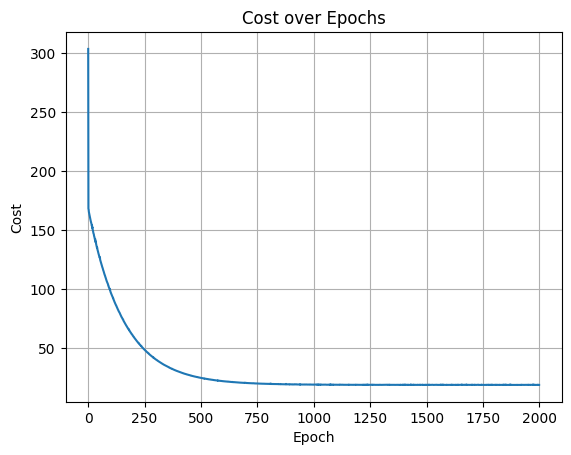

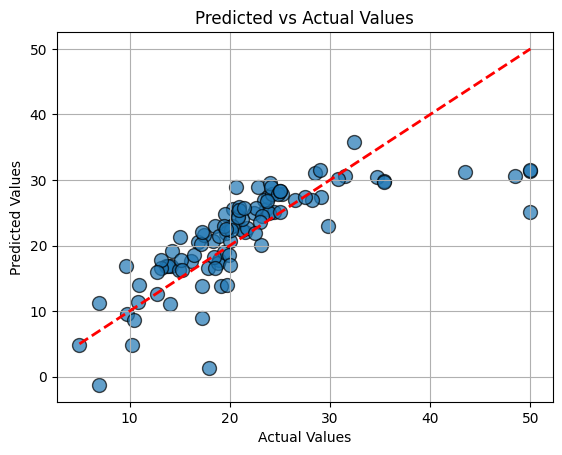

Parameters : [34.25580793  4.97935221 -0.96042641]
Mean Squared Error: 32.399774457890544
Mean Absolute Error: 3.9071763739166774
R-squared: 0.5581876038352218


In [36]:
df = pd.read_csv("boston.csv")
X = df[["CHAS","LSTAT"]]
Y = df["MEDV"]

my_lin_model = GLM(GLM_type = "linear", learning_rate = .001, max_epochs = 2000, convergence_level = .00001)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
my_lin_model.fit(X_train, Y_train,grad_type = "mini-batch")
my_lin_model.parameters()
Y_pred = my_lin_model.predict(X_test)

my_lin_model.plot_cost()
my_lin_model.plot_predict(Y_pred, Y_test)
my_lin_model.performance_metrics(Y_test, Y_pred)

sklearn linear regression

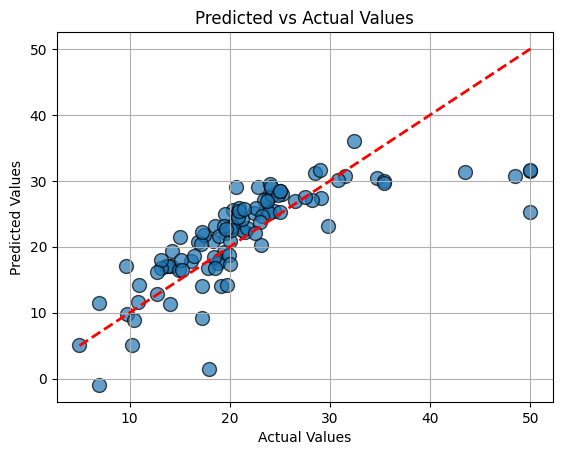

34.31494988461766 [ 5.0301961  -0.95361311]
Mean Squared Error: 32.42681807949245
Mean Absolute Error: 3.950810238612506
R-squared: 0.5578188294390778


In [37]:
sklearn_LR_model = LinearRegression()
sklearn_LR_model.fit(X_train, Y_train)

slope = sklearn_LR_model.coef_
intercept = sklearn_LR_model.intercept_

Y_pred = sklearn_LR_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

plt.scatter(Y_test, Y_pred, alpha=0.7, edgecolors="k", s=100)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--', lw=2)  # Reference line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.show()

print(intercept, slope)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")